In [1]:
library(tidyverse)
library(RcppCNPy)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Let's start by generating some X and Y.

In [2]:
#system2('nextflow', args = c('run', '../scripts/io/generate_non-linear_data.nf',
#                            '--n 100','--d 100','--causal 5','--out ./sets/original/'))

X <- npyLoad("./sets/original/X_train.npy") %>% t
Y <- npyLoad("./sets/original/Y_train.npy") %>% t

In [3]:
# Y = power(X[0,],[4]) + power(X[1,],[3]) + cos(X[2,],None) + cos(X[3,],None) + square(X[4,],None)
fx <- data_frame(X1 = X[,1], fX1 = X1^4, X1d = fX1/var(fX1),
                 X2 = X[,2], fX2 = X2^3, X2d = fX2/var(fX2),
                 X3 = X[,3], fX3 = cos(X3), X3d = fX3/var(fX3),
                 X4 = X[,4], fX4 = cos(X4), X4d = fX4/var(fX4),
                 X5 = X[,5], fX5 = X5^2, X5d = fX5/var(fX5),
                 Y = X1d + X2d + X3d + X4d + X5d)

Yold <- fx %>%
    mutate(idx = 1:n()) %>%
    gather(var, value, -idx, -Y)

cor(fx$Y, Y)

1


We are able to replicate the generation of the Y vector.

      X1d               X2d                 X3d             X4d       
 Min.   : 0.0000   Min.   : 0.000041   Min.   :31.97   Min.   :27.51  
 1st Qu.: 0.0184   1st Qu.: 0.274113   1st Qu.:42.90   1st Qu.:37.21  
 Median : 0.5448   Median : 1.595965   Median :49.93   Median :44.35  
 Mean   : 2.5154   Mean   : 3.279115   Mean   :47.86   Mean   :42.68  
 3rd Qu.: 3.4589   3rd Qu.: 4.754032   3rd Qu.:54.27   3rd Qu.:49.19  
 Max.   :14.2670   Max.   :14.646675   Max.   :57.01   Max.   :50.61  
      X5d           
 Min.   : 0.000234  
 1st Qu.: 1.058180  
 Median : 3.629210  
 Mean   : 4.171411  
 3rd Qu.: 6.832521  
 Max.   :10.506602  

       Y         
 Min.   : 70.57  
 1st Qu.: 93.58  
 Median : 99.86  
 Mean   :100.51  
 3rd Qu.:109.00  
 Max.   :126.03  

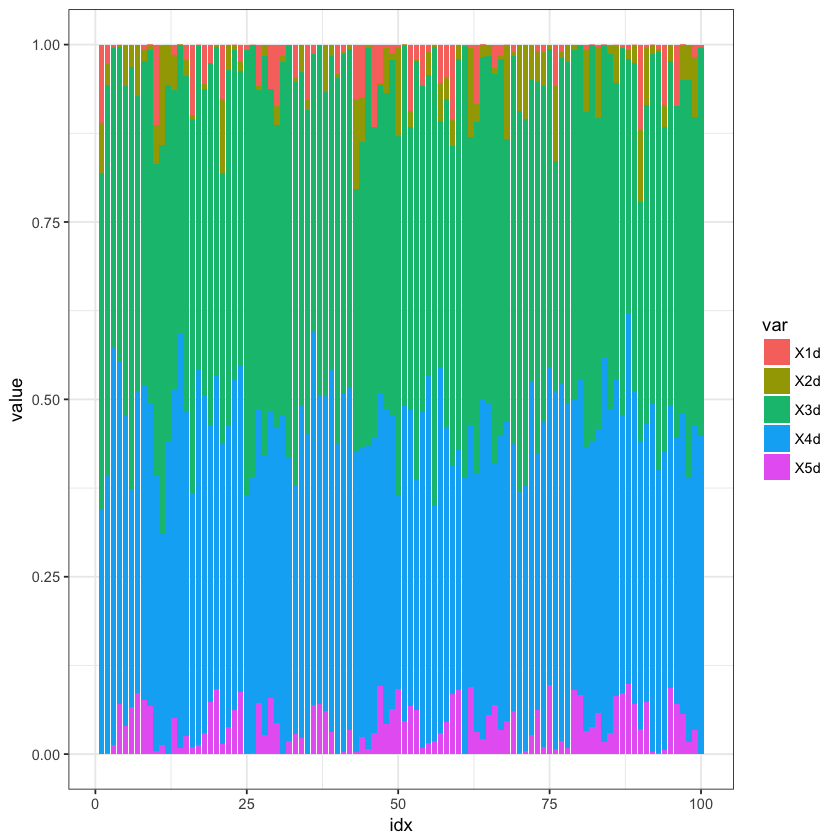

In [4]:
select(fx, ends_with('d')) %>% summary
select(fx, Y) %>% summary

Yold %>%
    filter(grepl('d$', var)) %>%
    ggplot(aes(x = idx, y = value, fill = var)) +
        geom_bar(stat = 'identity', position = 'fill') +
        theme_bw()

The contribution of each function is quite different. Functions with low variance (cos, possibly sin and log) end up with much higher values after normalization than functions with high variance.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


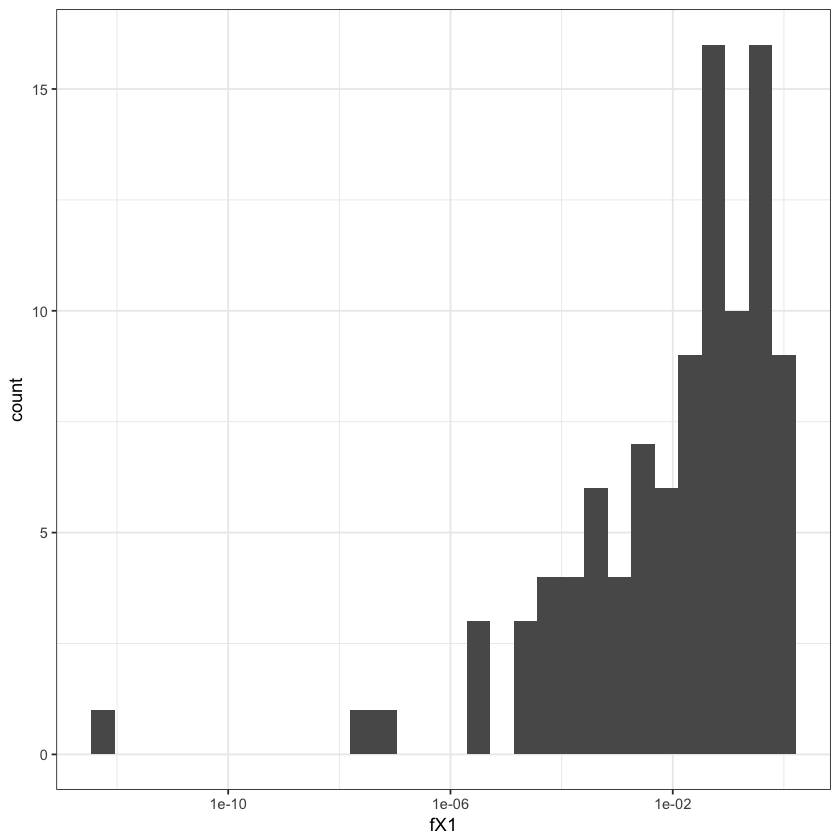

In [5]:
ggplot(fx, aes(fX1)) + geom_histogram() + scale_x_log10() + theme_bw()

On top of the variance, there is the fact that we are working with numbers between 0 and 1, so powers will just make these number closer and closer to 0. This is solvable by using a different range of numbers e.g. 0 - 10.

`geom_smooth()` using method = 'loess'


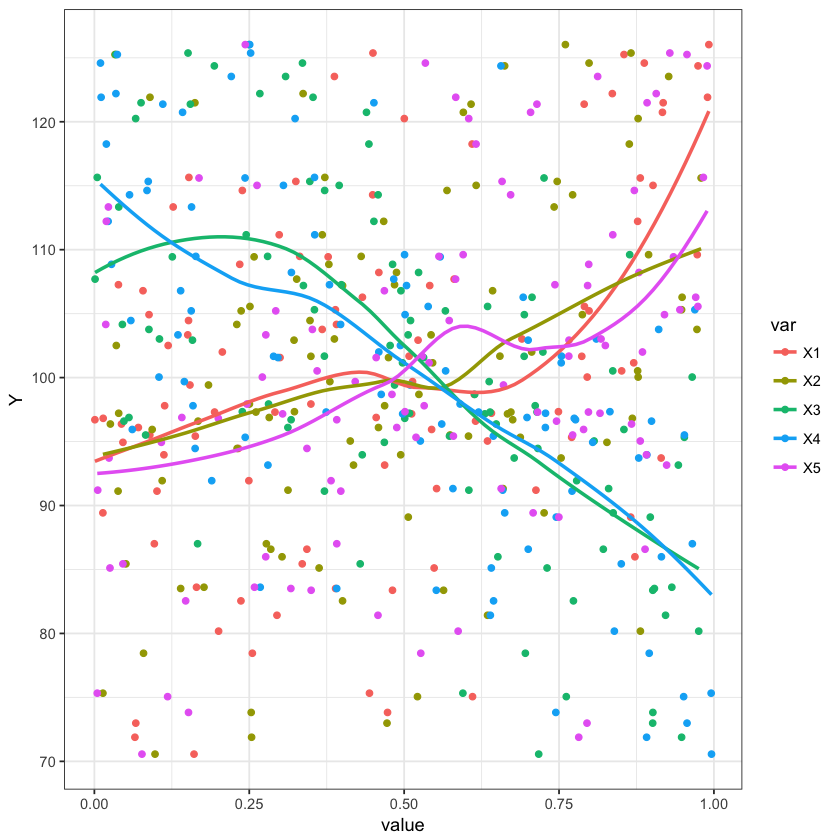

In [6]:
Yold %>%
    filter(! grepl('d', as.character(var))) %>%
    filter(! grepl('f', as.character(var))) %>%
    ggplot(aes(value, Y, color = var)) +
        geom_point() +
        geom_smooth(se = FALSE) +
        theme_bw()

On top of that, some functions show a linear-like behavior on the range 0 to 1 (sin and cos, see X3 and X4).

In summary, there are three problems with the current data generation method:

- Range between 0 and 1 is problematic for polynomial functions.
- Range between 0 and 1 is problematic for cos, sin and log functions.
- Normalizing using the variance is problematic for polynomial functions.

In [7]:
scale <- function(x) (x - min(x))/(max(x) - min(x))

X10 <- 10 * X
new <- data_frame(X1 = X10[,1], fX1 = X1^4, X1d = scale(fX1),
                  X2 = X10[,2], fX2 = X2^3, X2d = scale(fX2),
                  X3 = X10[,3], fX3 = cos(X3), X3d = scale(fX3),
                  X4 = X10[,4], fX4 = cos(X4), X4d = scale(fX4),
                  X5 = X10[,5], fX5 = X5^2, X5d = scale(fX5),
                  Y = X1d + X2d + X3d + X4d + X5d)

Ynew <- new %>%
    mutate(idx = 1:n()) %>%
    gather(var, value, -idx, -Y)

      X1d               X2d               X3d               X4d         
 Min.   :0.00000   Min.   :0.00000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.00129   1st Qu.:0.01871   1st Qu.:0.08028   1st Qu.:0.09802  
 Median :0.03818   Median :0.10896   Median :0.53018   Median :0.56652  
 Mean   :0.17631   Mean   :0.22388   Mean   :0.49457   Mean   :0.51427  
 3rd Qu.:0.24244   3rd Qu.:0.32458   3rd Qu.:0.84267   3rd Qu.:0.87925  
 Max.   :1.00000   Max.   :1.00000   Max.   :1.00000   Max.   :1.00000  
      X5d        
 Min.   :0.0000  
 1st Qu.:0.1007  
 Median :0.3454  
 Mean   :0.3970  
 3rd Qu.:0.6503  
 Max.   :1.0000  

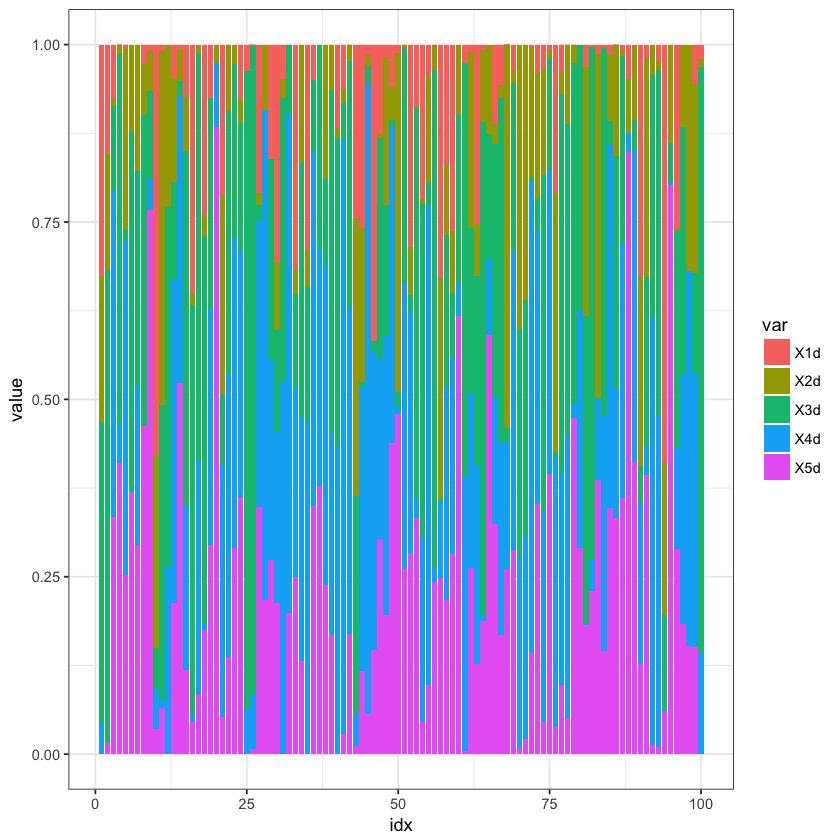

In [8]:
select(new, ends_with('d')) %>% summary

Ynew %>%
    filter(grepl('d$', var)) %>%
    ggplot(aes(x = idx, y = value, fill = var)) +
        geom_bar(stat = 'identity', position = 'fill') +
        theme_bw()

`geom_smooth()` using method = 'loess'


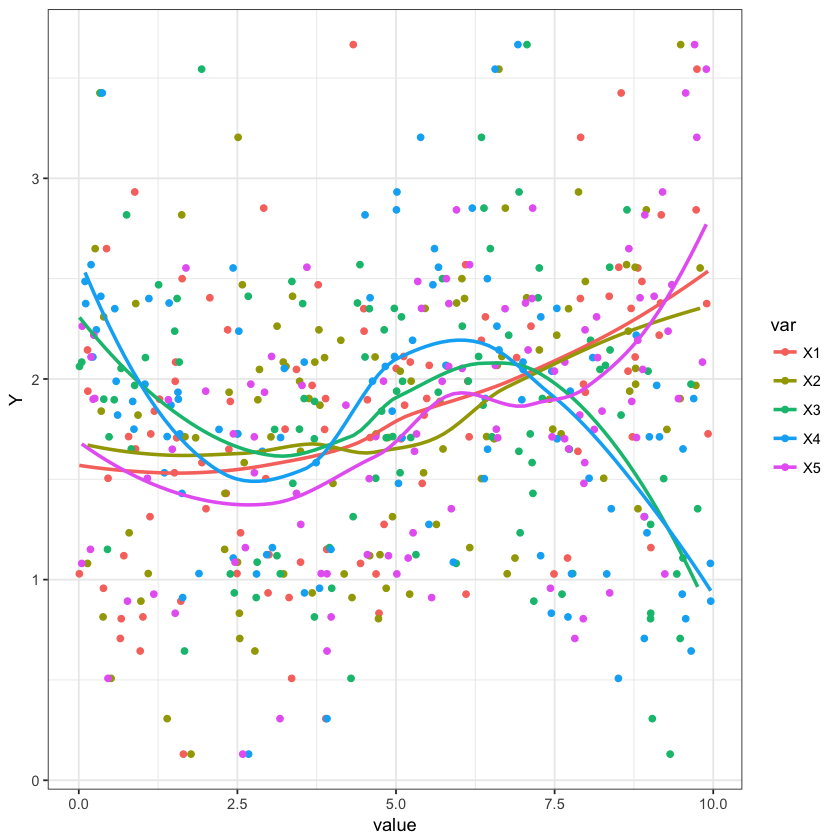

In [9]:
Ynew %>%
    filter(! grepl('d$', as.character(var))) %>%
    filter(! grepl('^f', as.character(var))) %>%
    ggplot(aes(value, Y, color = var)) +
        geom_point() +
        geom_smooth(se = FALSE) +
        theme_bw()

By altering the range and varying the normalization, we have altered how much each of the variables contribute to the weight and kept a non-linear behaviour. However, lower powers 4-5 seem more linearly relationed to the output. Hence, we will remove powers < 4 from the pool.

`geom_smooth()` using method = 'loess'


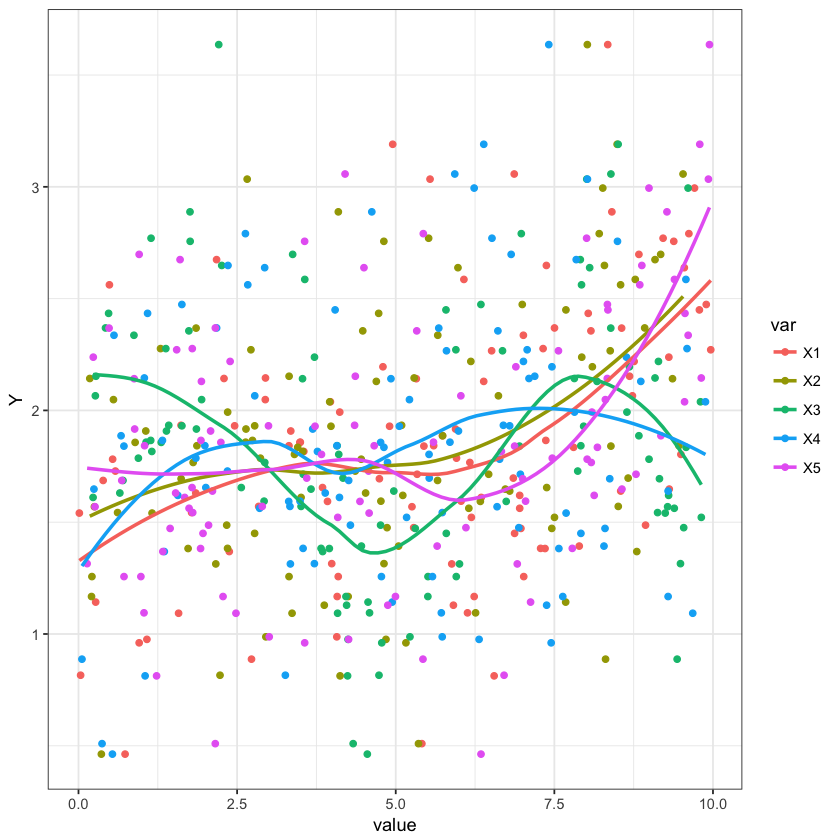

In [10]:
data_frame(X1 = X10[,23], fX1 = X1^4, X1d = scale(fX1),
           X2 = X10[,45], fX2 = X2^7, X2d = scale(fX2),
           X3 = X10[,76], fX3 = sin(X3), X3d = scale(fX3),
           X4 = X10[,8] , fX4 = log(X4), X4d = scale(fX4),
           X5 = X10[,53], fX5 = X5^9, X5d = scale(fX5),
           Y = X1d + X2d + X3d + X4d + X5d) %>%
    mutate(idx = 1:n()) %>%
    gather(var, value, -idx, -Y) %>%
    filter(! grepl('d$', as.character(var))) %>%
    filter(! grepl('^f', as.character(var))) %>%
    ggplot(aes(value, Y, color = var)) +
        geom_point() +
        geom_smooth(se = FALSE) +
        theme_bw()

Wonderfule.

In [11]:
train <- data_frame(X1 = X10[,23], fX1 = X1^4, X1d = scale(fX1),
                    X2 = X10[,45], fX2 = X2^7, X2d = scale(fX2),
                    X3 = X10[,76], fX3 = sin(X3), X3d = scale(fX3),
                    X4 = X10[,8] , fX4 = log(X4), X4d = scale(fX4),
                    X5 = X10[,53], fX5 = X5^9, X5d = scale(fX5),
                    Y = X1d + X2d + X3d + X4d + X5d)
X_train <- X10 %>% as.matrix
Y_train <- train$Y

X_test <- npyLoad("./sets/original/X_test.npy") %>% t
X_test <- X_test * 10

test <- data_frame(X1 = X_test[,23], fX1 = X1^4, X1d = scale(fX1),
                   X2 = X_test[,45], fX2 = X2^7, X2d = scale(fX2),
                   X3 = X_test[,76], fX3 = sin(X3), X3d = scale(fX3),
                   X4 = X_test[,8] , fX4 = log(X4), X4d = scale(fX4),
                   X5 = X_test[,53], fX5 = X5^9, X5d = scale(fX5),
                   Y = X1d + X2d + X3d + X4d + X5d)
X_test <- X_test %>% as.matrix
Y_test <- test$Y

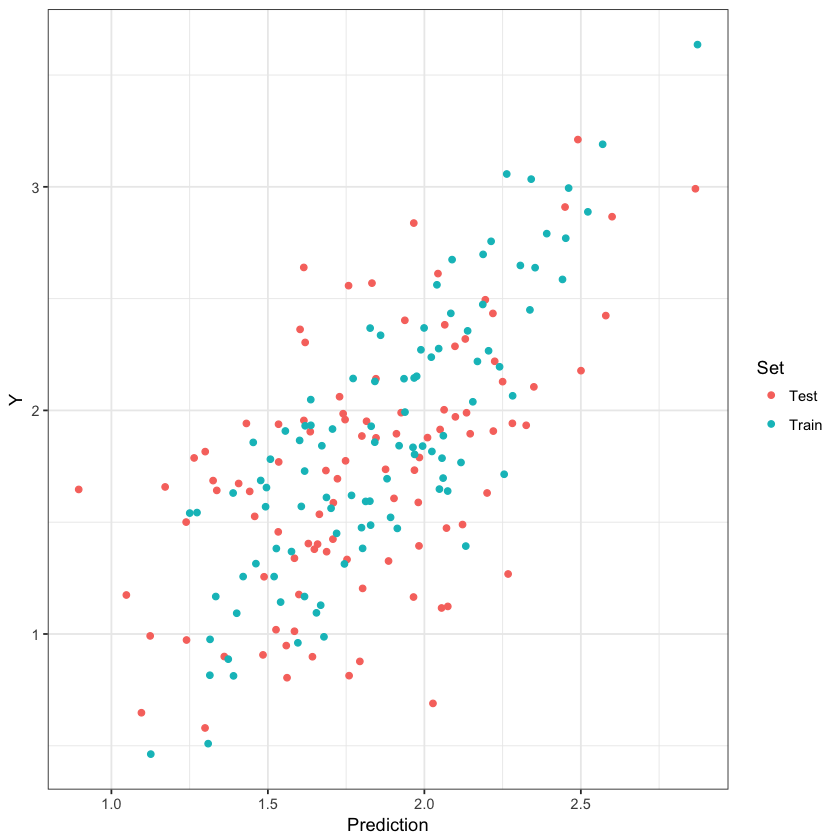

In [12]:
suppressPackageStartupMessages(library(glmnet))

cvfit = cv.glmnet(X_train, Y_train)

rbind(
    data_frame(Y = Y_test,
               Prediction = as.numeric(predict(cvfit, newx = X_test, s = "lambda.min")),
               Set = 'Test'),
    data_frame(Y = Y_train,
               Prediction = as.numeric(predict(cvfit, newx = X_train, s = "lambda.min")),
               Set = 'Train')) %>%
    ggplot(aes(Prediction, Y, color = Set)) +
        geom_point() +
        theme_bw()

In [13]:
coef(cvfit, s = "lambda.min")[which(coef(cvfit, s = "lambda.min") > 0),]
summary(coef(cvfit, s = "lambda.min")[which(coef(cvfit, s = "lambda.min") > 0),])

(Intercept)          V1          V2          V8         V23         V25 
0.475325649 0.020459798 0.014646442 0.036821696 0.067739590 0.008595521 
        V26         V31         V37         V41         V42         V45 
0.027280272 0.009896218 0.009182895 0.002159949 0.003615645 0.055759767 
        V46         V52         V53         V65         V88 
0.011258707 0.006719460 0.048308053 0.022781089 0.001589153

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001589 0.008596 0.014646 0.048361 0.036822 0.475326 

Lasso is able to achieve some decent accuracy (R<sup>2</sup> = 0.30 in the test set) by selecting the 2/5 causal features that resemble more a line (1 and 2), and 15 other variables.

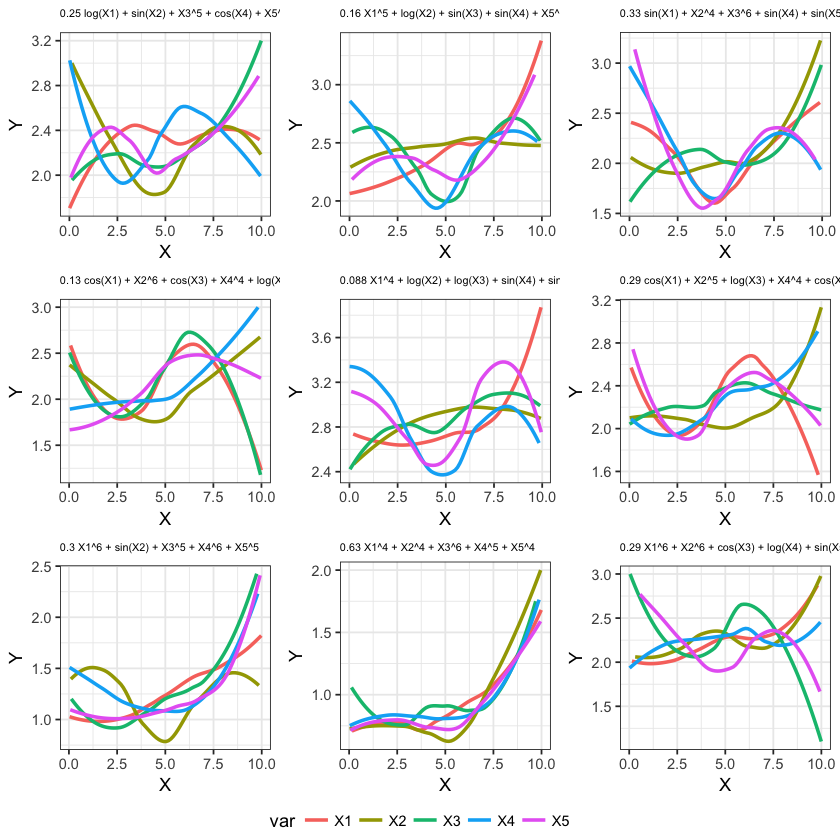

In [15]:
suppressPackageStartupMessages(library(cowplot))

ggs <- lapply(1:9, function(i) {
    o <- system2('nextflow', args = c('run', '../scripts/io/generate_non-linear_data.nf',
                                      '--n 100','--d 100','--causal 5'),
                 stdout = TRUE)
    formula <- gsub('Y = 0 \\+ ', '', o[5]) %>% 
        gsub(',None', '', .) %>% 
        gsub(',\\],\\[', ']^', .) %>% 
        gsub('\\]\\)', '', .) %>%
        gsub(',', '])', .) %>%
        gsub('power\\(', '', .) %>%
        gsub('\\[4\\]', '5', .) %>% gsub('\\[3\\]', '4', .) %>% 
        gsub('\\[2\\]', '3', .) %>% gsub('\\[1\\]', '2', .) %>% 
        gsub('\\[0\\]', '1', .)

    X <- npyLoad("X_train.npy") %>% t
    Y <- npyLoad("Y_train.npy") %>% t %>% as.numeric
    
    cvfit = cv.glmnet(X, Y)
    X_test <- npyLoad("X_test.npy") %>% t
    Y_test <- npyLoad("Y_test.npy") %>% t %>% as.numeric
    
    prediction <- predict(cvfit, newx = X_test, s = "lambda.min")
    
    r2 <- cor(prediction, Y_test)^2

    data_frame(X1 = X[,1], X2 = X[,2], X3 = X[,3],
               X4 = X[,4], X5 = X[,5], Y = Y) %>%
        mutate(idx = 1:n()) %>%
        gather(var, value, -idx, -Y) %>%
        ggplot(aes(value, Y, color = var)) +
            geom_smooth(method = 'loess', se = FALSE) +
            theme_bw() +
            labs(x = 'X', title = paste(format(r2, digits = 2), formula)) +
            theme(plot.title = element_text(size=6.5))
    
})

plots <- plot_grid(plotlist = lapply(ggs, function(p) p + theme(legend.position = 'None')), 
                   nrow = 3, ncol = 3)
legend <- get_legend(ggs[[1]] + theme(legend.position = 'bottom'))
                   
plot_grid(plots, legend, nrow = 2, rel_heights = c(20, 1))

Here I select simulate a few new datasets with the new methodology. Over each of the plots, there is the particular combination of variables that leads to it. For each variable, I display the mean Y at everypoint (note that there is considerable variance around it). On this datasets, I trained a Lasso classifier and calculated the R2 on test data. The R2 is displayed above each of the plots, right in front of the equation.